## Importing Libraries

In [1]:
from common_libraries import *
import project_function

In [2]:

spark = SparkSession.builder \
    .master("local[*]") \
    .config("spark.sql.debug.catalog", False) \
    .config("spark.logLevel", "ERROR") \
    .config("spark.dynamicAllocation.enabled", "true") \
    .config("spark.executor.memory", "8g") \
    .config("spark.executor.cores", "4") \
    .config("spark.driver.memory", "4g") \
    .config("spark.driver.cores", "2") \
    .getOrCreate()


spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/20 14:54:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Ingesting Data

In [3]:
df = spark.read.csv("/Users/pasqualesalomone/Desktop/crime_data.csv", header=True, inferSchema=True)
df.printSchema()

root
 |-- DR_NO: integer (nullable = true)
 |-- Date Rptd: string (nullable = true)
 |-- DATE OCC: string (nullable = true)
 |-- TIME OCC: integer (nullable = true)
 |-- AREA: integer (nullable = true)
 |-- AREA NAME: string (nullable = true)
 |-- Rpt Dist No: integer (nullable = true)
 |-- Part 1-2: integer (nullable = true)
 |-- Crm Cd: integer (nullable = true)
 |-- Crm Cd Desc: string (nullable = true)
 |-- Mocodes: string (nullable = true)
 |-- Vict Age: integer (nullable = true)
 |-- Vict Sex: string (nullable = true)
 |-- Vict Descent: string (nullable = true)
 |-- Premis Cd: integer (nullable = true)
 |-- Premis Desc: string (nullable = true)
 |-- Weapon Used Cd: integer (nullable = true)
 |-- Weapon Desc: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Status Desc: string (nullable = true)
 |-- Crm Cd 1: integer (nullable = true)
 |-- Crm Cd 2: integer (nullable = true)
 |-- Crm Cd 3: integer (nullable = true)
 |-- Crm Cd 4: integer (nullable = true)
 |-- L

In [4]:
print("Total numbers of rows is {} and the number of columns is {}".format(df.count(),len(df.columns)))

Total numbers of rows is 925720 and the number of columns is 28


In [5]:
#df.show(1,truncate=False, vertical=True)
df.toPandas().head()


,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,190326475,03/01/2020 12:00:00 AM,03/01/2020 12:00:00 AM,2130,7,Wilshire,784,1,510,VEHICLE - STOLEN,...,AA,Adult Arrest,510.0,998.0,NaN,NaN,1900 S LONGWOOD AV,None,34.0375,-118.3506
1,200106753,02/09/2020 12:00:00 AM,02/08/2020 12:00:00 AM,1800,1,Central,182,1,330,BURGLARY FROM VEHICLE,...,IC,Invest Cont,330.0,998.0,NaN,NaN,1000 S FLOWER ST,None,34.0444,-118.2628
2,200320258,11/11/2020 12:00:00 AM,11/04/2020 12:00:00 AM,1700,3,Southwest,356,1,480,BIKE - STOLEN,...,IC,Invest Cont,480.0,NaN,NaN,NaN,1400 W 37TH ST,None,34.0210,-118.3002
3,200907217,05/10/2023 12:00:00 AM,03/10/2020 12:00:00 AM,2037,9,Van Nuys,964,1,343,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),...,IC,Invest Cont,343.0,NaN,NaN,NaN,14000 RIVERSIDE DR,None,34.1576,-118.4387
4,220614831,08/18/2022 12:00:00 AM,08/17/2020 12:00:00 AM,1200,6,Hollywood,666,2,354,THEFT OF IDENTITY,...,IC,Invest Cont,354.0,NaN,NaN,NaN,1900 TRANSIENT,None,34.0944,-118.3277


## EDA (Exploratory Data Analysis)

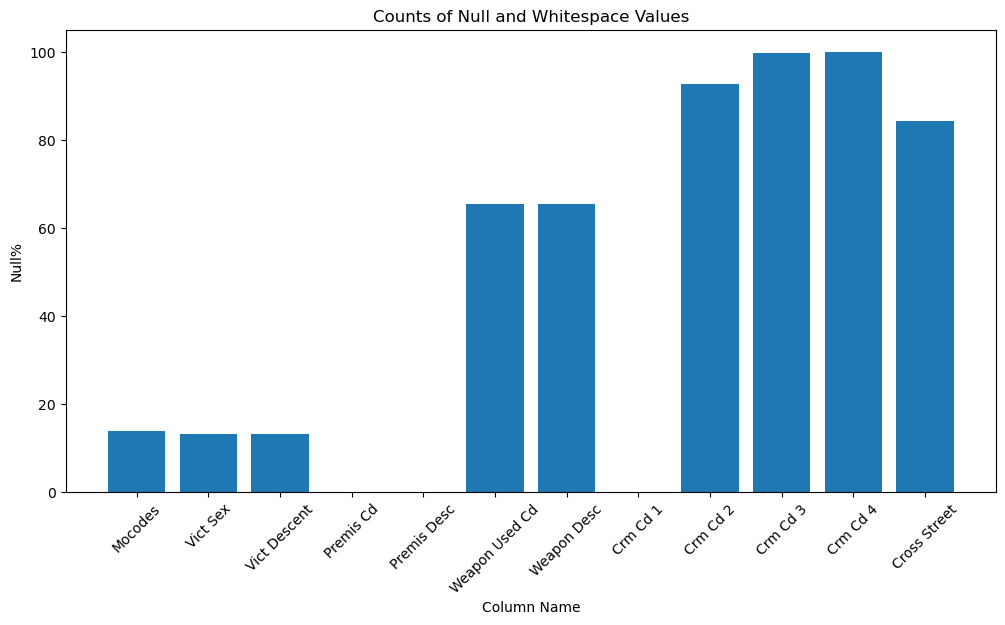

In [6]:
#df.filter(col('Crm Cd 3').isNull()).count()
project_function.nulls_buster_visual(df,spark)

In [14]:
project_function.unique_check(df, "DR_NO")

'Column DR_NO contains unique values'

<Figure size 1200x500 with 0 Axes>

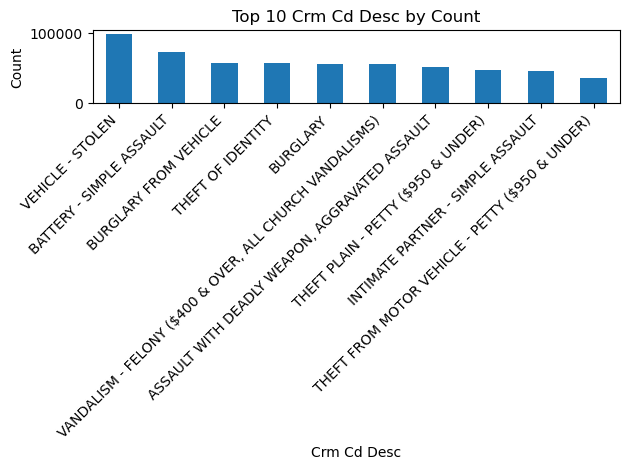

In [15]:
project_function.plot_top_n_bycolumn(df, "Crm Cd Desc")

In [16]:
#df.groupBy('Crm Cd Desc').agg(count('*').alias('Count')).orderBy('Count', ascending=False).limit(10).show()


<Figure size 1200x500 with 0 Axes>

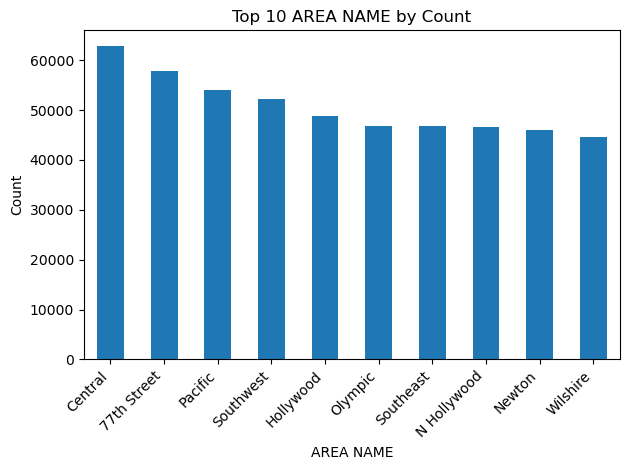

In [17]:
project_function.plot_top_n_bycolumn(df, "AREA NAME")

In [18]:
df.select('Date Rptd','TIME OCC').describe().show()

+-------+--------------------+------------------+
|summary|           Date Rptd|          TIME OCC|
+-------+--------------------+------------------+
|  count|              925720|            925720|
|   mean|                NULL|1337.4902087024154|
| stddev|                NULL| 652.6937534056576|
|    min|01/01/2020 12:00:...|                 1|
|    max|12/31/2023 12:00:...|              2359|
+-------+--------------------+------------------+



In [19]:
crime_by_area = df.groupBy(col('AREA NAME')).agg(F.count('*')).toPandas()


In [20]:
# Group by 'AREA NAME' and count the number of rows in each group
grouped_df = df.groupBy(col('AREA NAME')).agg(F.count('*').alias('row_count'))

# Calculate summary statistics: median and interquartile range (IQR)
quantiles = grouped_df.stat.approxQuantile("row_count", [0.25, 0.75], 0.01)
median = quantiles[0]
iqr = quantiles[1] - quantiles[0]

# Define lower and upper bounds for identifying outliers
lower_bound = median - 1.5 * iqr
upper_bound = median + 1.5 * iqr

# Filter rows where the row count is an outlier
outliers_df = grouped_df.filter((col("row_count") < lower_bound) | (col("row_count") > upper_bound))

outliers_df.show()

+-----------+---------+
|  AREA NAME|row_count|
+-----------+---------+
|    Central|    62852|
|    Pacific|    53984|
|  Southwest|    52140|
|77th Street|    57878|
+-----------+---------+

